# Simulating orbits with REBOUND

https://rebound.readthedocs.io/en/latest/api/


In [2]:
pip install rebound

  Using cached rebound-3.28.4-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (709 kB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
%matplotlib widget
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import rebound

To run an N-body simulation, we need to create a simulation object first. We will also choose units that are convenient for astronomy.

In [4]:
sim = rebound.Simulation()
sim.units = ('AU','yr','Msun')
sim.G = 39.476926408897626

Then, we add bodies to the simulation. We will star with the star (1.5 solar masses) add then planets in the system from the inside out. Six parameters are required to uniquely specify the orbit of each planet of mass m, and we will use the following observationally determined ones:
 - semi-major axis (a) in au
 - eccentricity (e)
 - inclination (i) in radians
 - PA of the ascending node (Ω) in radians
 - argument of periastron (ω) in radians
 - mean anomaly at a reference epoch (MA_ref) in radians
 

In [5]:
# Central star HR 8799 A
#sim.add(m=1e-6)                
sim.add(m=1.50)                

# co-planar orbits
dtor = np.pi / 180
inc_pl = 27.8 * dtor
Omega_pl = 60.1 * dtor

# planet masses
mass_e = 5e-3
mass_d = mass_e

# add inner most planet: HR 8799 e
sim.add(m=mass_e, a=16.64, e=0.1397, omega=118.8*dtor, M=1.261, inc=inc_pl, Omega=Omega_pl)
# add next planet: HR 8799 d
sim.add(m=mass_d, a=26.29, e=0.1112, omega=24.3*dtor, M=2.032, inc=inc_pl, Omega=Omega_pl)

Now let's set the time steps for numerical integration. A general rule of thumb is that time steps should be at most 10% of the shortest orbital period. The following will compute all orbital elements for our simlated particles and print out their periods. We then select an appropriate time step.

In [6]:
# compute and print orbital period of each planet
print("   P (yr) ")
for o in sim.calculate_orbits(): 
    print("%9.3f" % o.P)

# set the time step
sim.dt = 1.0

   P (yr) 
   55.331
  109.700


We want to work in the center-of-mass frame throughout this simulation. Now that we have set up some planets we can do that. Let's look at the positions of the host star and two planets before integrating our simulation forward. Are their distances from the origin about where we expect them?

In [7]:
# move to center of mass frame
sim.move_to_com()

# examine initial locations of particles
print("   X (au)    Y (au)    Z (au) ")
for p in sim.particles:
    print("%9.3f %9.3f %9.3f" % (p.x,p.y,p.z))

   X (au)    Y (au)    Z (au) 
    0.079     0.103    -0.009
   -1.495   -15.694    -3.442
  -22.322   -15.261     6.191


For fun, let's plot what the orbits we've specified look like and where our planets are to start out with. We'll also save this first timestep so that we can return to it later.

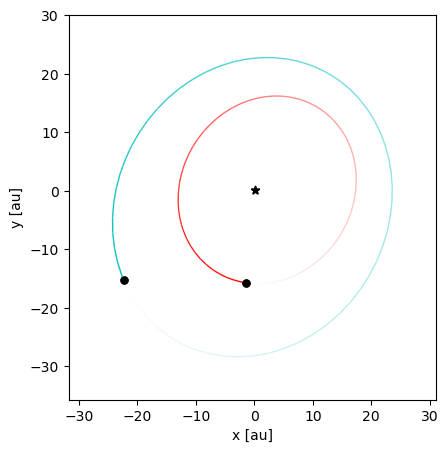

In [8]:
# plot our starting point
op = rebound.OrbitPlot(sim, color=True, periastron=False, unitlabel="[au]")

# save our starting point
sim.save("start.bin")

Now let's actually integrate the orbits forward. The code below will iteratively integrate more and more time, stopping occasionally to display where the planets are at. Feel free to play with the number of frames and the time between displaying frames

Note: once you've run this block once, the simulation will always pick up where you left off. It won't start from the initial conditions. This is good if you want to keep exploring farther and farther in time, but bad if you want to re-run the experiment to check numbers.

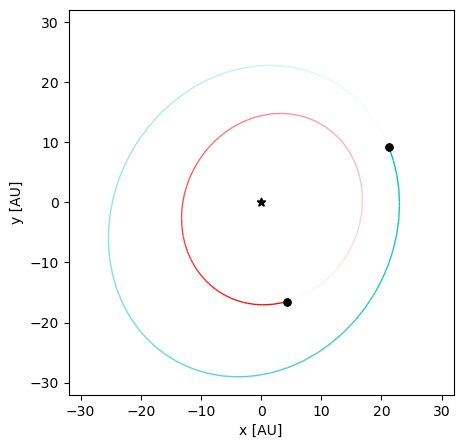

In [9]:
nframe = 100 # at home, I found 100 frames takes about 30 seconds to render
framestep = 5*sim.dt

op = rebound.OrbitPlot(sim,color=True,unitlabel="[AU]",xlim=[-32,32.],ylim=[-32,32.])
fig = op.fig
for i in range(nframe):
    sim.integrate(sim.t + framestep)
    op.update()       # update data
    fig.canvas.draw() # redraw figure

Let's see if the orbital elements of the planets have changed. In a stable system, they should only change negligibly with time.

In [10]:
# check time run so far
sim.status(showAllFields=False)

# move to center of mass frame
sim.move_to_com()

# compute and print orbital elements of each planet
print()
print("      a (au)          e       omega (deg)  inc (deg)    Omega (deg)")
for o in sim.calculate_orbits(): 
    print("%12.4f %12.4f %12.4f %12.4f %12.4f " % (o.a, o.e, o.omega/dtor, o.inc/dtor, o.Omega/dtor))

---------------------------------
REBOUND version:     	3.28.4
REBOUND built on:    	Oct 20 2023 17:23:40
Number of particles: 	3
Selected integrator: 	ias15
Simulation time:     	5.0000000000000000e+02
Current timestep:    	0.986330
---------------------------------
<rebound.particle.Particle object at 0x7f3465f54c40, m=1.5 x=-0.0849819736948084 y=0.024538575582531023 z=0.045291395723564505 vx=-0.0032791714991404213 vy=-0.006055152420327716 vz=-9.264460663797682e-05>
<rebound.particle.Particle object at 0x7f3465e6b0c0, m=0.005 x=4.269363325339819 y=-16.515288686780792 z=-6.291961099334639 vx=1.5396564793888345 vy=0.4197186461780604 vz=-0.5934080928260154>
<rebound.particle.Particle object at 0x7f3465f54c40, m=0.005 x=21.225228783102402 y=9.15371601202155 z=-7.2954576177345904 vx=-0.5559050296467084 vy=1.3968270799202545 vz=0.6212014748174088>
---------------------------------

      a (au)          e       omega (deg)  inc (deg)    Omega (deg)
     16.5003       0.1522      88.3088   

There are actually two more (known) planets in the HR 8799 system. So let's go ahead and return to our original time step and add those in.

In [11]:
# reset sim
del sim
sim = rebound.Simulation("start.bin")

# planet masses
mass_c = mass_e
mass_b = 3e-3

sim.add(m=mass_c, a=43.12, e=0.0561, omega=28.5*dtor, M=4.232, inc=inc_pl, Omega=Omega_pl)
sim.add(m=mass_b, a=70.50, e=0.0113, omega=213.6*dtor, M=2.642, inc=inc_pl, Omega=Omega_pl)

# move to center of mass frame
sim.move_to_com()

# verify the reset
sim.status(showAllFields=False)

# compute and print orbital elements of each planet
print()
print("      a (au)          e       omega (deg)  inc (deg)    Omega (deg)")
for o in sim.calculate_orbits(): 
    print("%12.4f %12.4f %12.4f %12.4f %12.4f " % (o.a, o.e, o.omega/dtor, o.inc/dtor, o.Omega/dtor))

---------------------------------
REBOUND version:     	3.28.4
REBOUND built on:    	Oct 20 2023 17:23:40
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	0.0000000000000000e+00
Current timestep:    	1.000000
---------------------------------
<rebound.particle.Particle object at 0x7f3465e6b240, m=1.5 x=-0.08601052489003369 y=0.05009831148480151 z=0.05247918880877085 vx=-0.007894407743755666 vy=0.0009906727450220013 vz=0.0038686115064337483>
<rebound.particle.Particle object at 0x7f3465e6b940, m=0.005 x=-1.6599408347471287 y=-15.74663059281168 z=-3.3798758555960426 vx=1.7096727450262574 vy=-0.25869130922962563 vz=-0.849417787860531>
<rebound.particle.Particle object at 0x7f3465e6b240, m=0.005 x=-22.48723909720716 y=-15.314447978592684 z=6.253094951842233 vx=0.5042477054269283 vy=-1.20751521326713 vz=-0.5478353640954631>
<rebound.particle.Particle object at 0x7f3465e6b940, m=0.005 x=31.981426325924506 y=-22.58483791182247 z=-20.553330101607727 vx=0.59687170148405

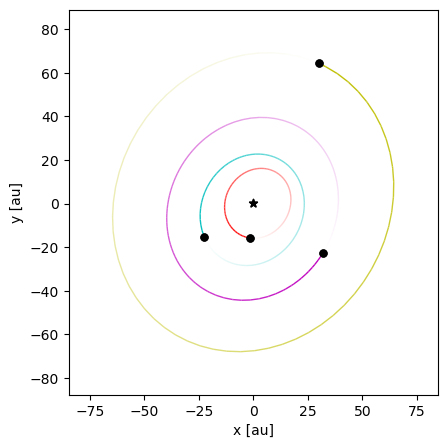

In [12]:
op = rebound.OrbitPlot(sim, color=True, periastron=False, unitlabel="[au]")

Now let's run a long integration and then see how it looks at the end. (You can try running for as long as you like!)

In [13]:
# run simulation
sim.integrate(100000)

# compute and print orbital elements of each planet
print()
print("      a (au)          e       omega (deg)  inc (deg)    Omega (deg)")
for o in sim.calculate_orbits(): 
    print("%12.4f %12.4f %12.4f %12.4f %12.4f " % (o.a, o.e, o.omega/dtor, o.inc/dtor, o.Omega/dtor))
    
# sim.status(showAllFields=False)


      a (au)          e       omega (deg)  inc (deg)    Omega (deg)
     16.6011       0.1268     240.0454      27.8000      60.1000 
     26.5685       0.1147     141.8462      27.8000      60.1000 
     42.7765       0.0330     318.3331      27.8000      60.1000 
     70.2771       0.0068      90.1207      27.8000      60.1000 


Now let's consider the motion of the star with respect to the barycentre by zooming in on it.

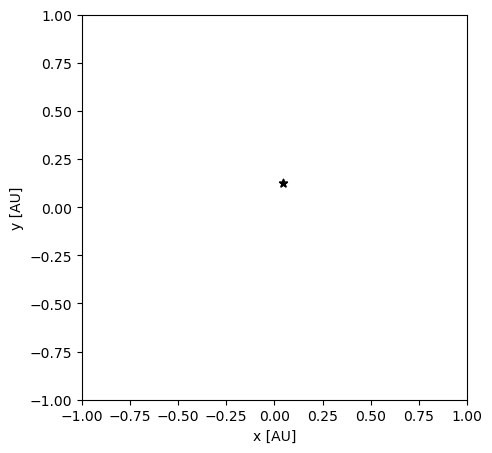

In [14]:
nframe = 100 # at home, I found 100 frames takes about 30 seconds to render
framestep = 5*sim.dt

op = rebound.OrbitPlot(sim,color=True,unitlabel="[AU]",xlim=[-1,1],ylim=[-1,1])
fig = op.fig
for i in range(nframe):
    sim.integrate(sim.t + framestep)
    op.update(updateLimits=True)
    fig.canvas.draw()

Finally, let's completely reimagine the system by assigning them the same orbital parameters but higher masses. Play with increasing the masses until you start to see dynamical instabilities show up in the animation. Based on their luminosities, we expect e, d, and c to all be about the same mass, and b is expected to be a bit lower.

In [15]:
# reset sim
del sim
sim = rebound.Simulation()

# Central star HR 8799 A
sim.add(m=1.50)                

# planet masses
mass_e = 7.3e-3
mass_d = mass_e
mass_c = mass_e
mass_b = mass_e * 0.5

sim.add(m=mass_e, a=16.64, e=0.1397, omega=118.8*dtor, M=1.261, inc=inc_pl, Omega=Omega_pl)
sim.add(m=mass_d, a=26.29, e=0.1112, omega=24.3*dtor, M=2.032, inc=inc_pl, Omega=Omega_pl)
sim.add(m=mass_c, a=43.12, e=0.0561, omega=28.5*dtor, M=4.232, inc=inc_pl, Omega=Omega_pl)
sim.add(m=mass_b, a=70.50, e=0.0113, omega=213.6*dtor, M=2.642, inc=inc_pl, Omega=Omega_pl)

sim.move_to_com()

After setting the planet masses, run the simulation. You may want to adjust nframe to make it run longer, but if you haven't broken it in 1000000 steps then then reset the masses above and try again. Alternatively, if you set the masses so high that it break immediately, try reducing them. We want to find an approximate mass that drives the system unstable within ~one million years.

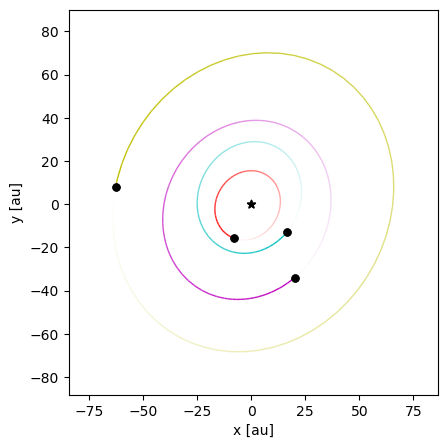

In [18]:
# run simulation
sim.integrate(10000)

# plot endpoint
op = rebound.OrbitPlot(sim, color=True, periastron=False, unitlabel="[au]")

In [20]:
# use this for reporting the final state of your simulation
sim.status(showAllFields=False)

---------------------------------
REBOUND version:     	3.28.4
REBOUND built on:    	Oct 20 2023 17:23:40
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0000000000000000e+04
Current timestep:    	7.037338
---------------------------------
<rebound.particle.Particle object at 0x7f3465ca29c0, m=1.5 x=0.013175445810294825 y=0.2859765745237652 z=0.06913914924488368 vx=-0.002542680934741634 vy=-0.0008092799112574844 vz=0.0009494676936406595>
<rebound.particle.Particle object at 0x7f3465ca2040, m=0.0073 x=-7.8214728723460025 y=-15.810434400885995 z=-0.58043782965129 vx=0.2306190996786802 vy=-0.0821996533908654 vz=-0.12701135330700647>
<rebound.particle.Particle object at 0x7f3465ca29c0, m=0.0073 x=16.502379779341553 y=-12.880409406807285 z=-10.927888879022904 vx=0.1670423408730531 vy=0.20260915445477354 vz=-0.023098541762178033>
<rebound.particle.Particle object at 0x7f3465ca2040, m=0.0073 x=20.008736440549217 y=-34.034850764274346 z=-18.09038296716271 vx=0.13871